# Metabolism Questions

## Debug

In [2]:
from cobra.io import load_matlab_model
import os


In [9]:
k12fam = [f for f in os.listdir("/Mounts/rbg-storage1/datasets/Metabo/BiGG") if "K-12" in f]

In [10]:
k12fam

[]

In [11]:
model = load_matlab_model("/Mounts/rbg-storage1/datasets/Metabo/BiGG/iML1515.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [24]:
reactions = model.reactions

In [25]:
reactions[271]

Reaction identifier,EDTXS3
Name,Endotoxin Synthesis (palmitoleoyl ACP)
Memory address,0x7efdbbb96dc0
Stoichiometry,hdeACP_c + kdo2lipid4_c --> ACP_c + kdo2lipid4p_c Cis-hexadec-9-enoyl-[acyl-carrier protein] (n-C16:1) + KDO(2)-lipid IV(A) --> Acyl carrier protein + KDO(2)-lipid IV(A) with palmitoleoyl
GPR,b2378
Lower bound,0.0
Upper bound,1000.0


In [ ]:
biocyc = [f for f in db_meta.values[0].split(";") if "biocyc" in f]

In [ ]:
db_meta = BIGG_METABOLITES[BIGG_METABOLITES["bigg_id"] == metabolite.id][
        "database_links"
    ]

# Datasets

In [40]:
from collections import defaultdict
import time
import pandas as pd
import numpy as np
from scipy.io import loadmat
# import escher
# from escher import Builder
import cobra
from cobra.io import load_matlab_model, load_json_model, save_json_model, load_model
# import cobramod
import json, copy
import os
from xml.etree import cElementTree as ET
from tqdm import tqdm
import re
import copy
import requests
from cobra.core.metabolite import Metabolite
from bioservices import ChEBI
import warnings

In [41]:
def xml2dict(t):
    d = {}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(xml2dict, children):
            for k, v in dc.items():
                if (not k == "") and not ("reference" in k):
                    dd[k.split("}")[-1]].append(v)
        d = {
            t.tag.split("}")[-1]: {
                k.split("}")[-1]: v[0] if len(v) == 1 else v for k, v in dd.items()
            }
        }

    if t.text:
        text = t.text.strip()
        if (not text == "") and not ("reference" in text):
            d[t.tag] = text
    return d

Outstanding questions:
- Experimental val
- Link to drug: drugbank to target id
- Link to disease (kg): Get disease ids from json; API to download individual diseases; biopython kgml to parse
- Link to drug screen db (depmap, cmap): 


for masking:
    data is: mini-pathways 
for gap filling: 
    network -> growth/no growth
for flux:
    network -> edge labels

validate reaction? 

```
Data Structure:
    {
        "metabolites": {},  # id to metadata
        "drugs": {},        # id to metadata
        "proteins": {},     # id to metadata
        "reactions": {}, 
        "pathways/groups" ?
        "network" ? 
    }
```


- Use cobrapy with BiGG models 
- Use cobramod to get KEGG if need be
- BioPython integrate other databases

------------
TODO:

- [ ] Get list of pathways per organism
- [ ] Programmatically make pathways and add to model
- [ ] Save as mat files
- [ ] Make drugbank and hmdb metadata files


# KEGG


- KEGG NETWORK represents a renewed attempt by KEGG to capture knowledge of diseases and drugs in terms of perturbed molecular networks

: Metabolic pathways -> individual pathways and reactions

```
pathway
|
|-- module
|    |
|    |-- reactions
```

In [4]:
from cobramod import create_object
from pathlib import Path
from cobramod.parsing.kegg import retrieve_data
from cobramod import get_data
import cobramod
from cobra import Model

In [13]:
# Using copy of test model
test_model = Model('test_model')

In [48]:
newobj= retrieve_data(
    directory = Path.cwd().resolve().joinpath("tempdir"),
    identifier="hsa05210")  # M00051

In [49]:
newobj

{'ENTRY': ['hsa05210                    Pathway'],
 'NAME': ['Colorectal cancer - Homo sapiens (human)'],
 'DESCRIPTION': ['Colorectal cancer (CRC) is the second largest cause of cancer-related deaths in Western countries. CRC arises from the colorectal epithelium as a result of the accumulation of genetic alterations in defined oncogenes and tumour suppressor genes (TSG). Two major mechanisms of genomic instability have been identified in sporadic CRC progression. The first, known as chromosomal instability (CIN), results from a series of genetic changes that involve the activation of oncogenes such as K-ras and inactivation of TSG such as p53, DCC/Smad4, and APC. The second, known as microsatellite instability (MSI), results from inactivation of the DNA mismatch repair genes MLH1 and/or MSH2 by hypermethylation of their promoter, and secondary mutation of genes with coding microsatellites, such as transforming growth factor receptor II (TGF-RII) and BAX. Hereditary syndromes have ger

# Escher

In [ ]:

"""
gen_map() passing the Cobra model, a list of
the reactions you wish to include and a list of metabolites you do
not wish to be used to create links between reactions (e.g. ATP). This
returns an EscherMap object. Use map_obj.dump_json() to get a JSON that
can be passed to escher.Builder()
"""
import sys
sys.path.append("escher_helper")
from escher_helper.generate_escher_map import gen_map

recon3 = load_matlab_model('/Mounts/rbg-storage1/datasets/Metabo/Recon3D/Recon3D_301/Recon3D_301.mat')

reactions_of_interest = list(recon3.groups[0].members)
metabolites_of_interest = list(set([l.id for m in recon3.groups[0].members for l in list(m.metabolites.keys())]))
bldr = gen_map(recon3,  reactions_of_interest, metabolites_of_interest)

---------------------------
# HMDB (Done)

In [11]:
metabolites_db = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/HMDB/metabolites.json", 'r'))

In [12]:
protein_db = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/HMDB/proteins.json", 'r'))

# Drug Bank (To Parse)

In [14]:
# enzymes that are targets
targets = pd.read_csv("drugbank_all_target_polypeptide_ids/all.csv")
enzymes = pd.read_csv("drugbank_all_enzyme_polypeptide_ids/all.csv")
approved = pd.read_csv("drugbank_approved_target_polypeptide_ids/all.csv")

targets_as_enzymes = [ t for t in set(targets['UniProt ID']) if t in set(enzymes['UniProt ID'])]
approved_targets_as_enzymes = [ t for t in targets_as_enzymes if t in set(approved['UniProt ID'])]

summary = "Targets that are enzymes: {}, Found in HMDB: {} \
\nTargets that are enzymes for approved drugs: {}, Found in HMDB: {}"

print( 
    summary.format(
    len(targets_as_enzymes), len([t for t in targets_as_enzymes if hmdb_to_uniprot.get(t, False) ]),
    len(approved_targets_as_enzymes), len([t for t in approved_targets_as_enzymes if hmdb_to_uniprot.get(t, False) ]))
)

Targets that are enzymes: 324, Found in HMDB: 287 
Targets that are enzymes for approved drugs: 273, Found in HMDB: 249


In [2]:
proteins = []
with open("protein.fasta", "r") as f:
    for line in f:
        if line.startswith("HMDBP"):
            proteins.append(line.split(' ')[0])

In [3]:
len(proteins)

5629

In [46]:
drugbank_levels = defaultdict(list)

n = 0
level = 0
entries = 0
start_time = time.time()
for event, elem in ET.iterparse('../DrugBank/drugbank.xml', events=('start', 'end') ):
    if event == 'start':
        level += 1
        if elem.tag.split('}')[-1] not in drugbank_levels[f"l{level}"]:
            drugbank_levels[f"l{level}"].append(elem.tag.split('}')[-1])
        if level == 2:
            entries += 1
    
    if event == 'end':
        level -= 1


    if n % 10e6 == 0:
        mins = round((time.time() - start_time)/60, 4)
        print("Processed {} entries in {} minutes".format(entries, mins))
    
    n+=1

Processed 0 entries in 0.0001 minutes
Processed 528 entries in 0.391 minutes
Processed 1024 entries in 0.757 minutes
Processed 3929 entries in 1.1797 minutes
Processed 8221 entries in 1.5274 minutes
Processed 10415 entries in 1.8946 minutes


In [48]:
drugbank_levels

defaultdict(list,
            {'l1': ['drugbank'],
             'l2': ['drug'],
             'l3': ['drugbank-id',
              'name',
              'description',
              'cas-number',
              'unii',
              'state',
              'groups',
              'general-references',
              'synthesis-reference',
              'indication',
              'pharmacodynamics',
              'mechanism-of-action',
              'toxicity',
              'metabolism',
              'absorption',
              'half-life',
              'protein-binding',
              'route-of-elimination',
              'volume-of-distribution',
              'clearance',
              'classification',
              'salts',
              'synonyms',
              'products',
              'international-brands',
              'mixtures',
              'packagers',
              'manufacturers',
              'prices',
              'categories',
              'affected-organisms',
 

# BiGG Models

In [49]:
model = load_matlab_model(f"/Mounts/rbg-storage1/datasets/Metabo/BiGG/e_coli_core.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [50]:
model

Name,e_coli_core
Memory address,0x07f11a09ebf70
Number of metabolites,72
Number of reactions,95
Number of groups,11
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"e, c"


In [51]:
val, = model.groups[0].members[0].genes

In [52]:
val

Gene identifier,b3956
Name,
Memory address,0x7f11a0a006d0
Functional,True
In 1 reaction(s),PPC


In [ ]:
metabolite2pathway = {}
for pathway in model.groups:
    for reaction in pathway.members:
        for metabolite in reaction.metabolites:
            metabolite2pathway.setdefault(metabolite.id, set())
            metabolite2pathway[metabolite.id].add(pathway.id)

In [ ]:
sorted({(k, len(v)) for k,v in metabolite2pathway.items()}, key=lambda x: x[1], reverse=True)

72

In [ ]:
from bioservices import UniProt

In [6]:
u = UniProt()

In [14]:
u.mapping("P_ENTREZGENEID", "ACC", query='314')

defaultdict(list, {'314': ['O75106']})

In [15]:
df = u.get_df(['O75106'])

/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/fba/lib/python3.10/site-packages/bioservices/uniprot.py:812: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(df, ignore_index=True)


In [13]:
pd.set_option('display.max_columns', None)
df[(df['Entry'] == 'Q9UJ70') | (df['Entry'] == 'A0A384N6G7') | (df['Entry'] ==  'C9JEV6')]

,Entry,Entry name,Gene names,Gene names (primary ),Gene names (synonym ),Gene names (ordered locus ),Gene names (ORF ),Organism,Organism ID,Protein names,Proteomes,Taxonomic lineage (ALL),Taxonomic lineage IDs,Virus hosts,Fragment,Sequence,Length,Mass,Gene encoded by,Alternative products (isoforms),Erroneous gene model prediction,Erroneous initiation,Erroneous termination,Erroneous translation,Frameshift,Mass spectrometry,Polymorphism,RNA editing,Sequence caution,Alternative sequence,Natural variant,Non-adjacent residues,Non-standard residue,Non-terminal residue,Sequence conflict,Sequence uncertainty,Version (sequence),Domains,Domain count,Domain [CC],Sequence similarities,Coiled coil,Compositional bias,Domain [FT],Motif,Region,Repeat,Zinc finger,EC number,Absorption,Catalytic activity,Cofactor,Function [CC],Kinetics,Pathway,Redox potential,Temperature dependence,pH dependence,Active site,Binding site,DNA binding,Metal binding,Nucleotide binding,Site,Gene ontology (GO),Gene ontology (biological process),Gene ontology (molecular function),Gene ontology (cellular component),Gene ontology IDs,InterPro,Interacts with,Subunit structure [CC],PubMed ID,Mapped PubMed ID,Date of creation,Date of last modification,Date of last sequence modification,Version (entry),3D,Beta strand,Helix,Turn,Subcellular location [CC],Intramembrane,Topological domain,Transmembrane,Annotation,Features,Caution,Tissue specificity,Miscellaneous [CC],Keywords,Protein existence,Status,Sequence annotation (Features),Protein families,Version,Comments,Cross-reference (null),Keyword ID,Pathway.1,Allergenic properties,Biotechnological use,Disruption phenotype,Involvement in disease,Pharmaceutical use,Toxic dose,Post-translational modification,Chain,Cross-link,Disulfide bond,Glycosylation,Initiator methionine,Lipidation,Modified residue,Peptide,Propeptide,Signal peptide,Transit peptide,Taxonomic lineage (all),Taxonomic lineage (SUPERKINGDOM),Taxonomic lineage (KINGDOM),Taxonomic lineage (SUBKINGDOM),Taxonomic lineage (SUPERPHYLUM),Taxonomic lineage (PHYLUM),Taxonomic lineage (SUBPHYLUM),Taxonomic lineage (SUPERCLASS),Taxonomic lineage (CLASS),Taxonomic lineage (SUBCLASS),Taxonomic lineage (INFRACLASS),Taxonomic lineage (SUPERORDER),Taxonomic lineage (ORDER),Taxonomic lineage (SUBORDER),Taxonomic lineage (INFRAORDER),Taxonomic lineage (PARVORDER),Taxonomic lineage (SUPERFAMILY),Taxonomic lineage (FAMILY),Taxonomic lineage (SUBFAMILY),Taxonomic lineage (TRIBE),Taxonomic lineage (SUBTRIBE),Taxonomic lineage (GENUS),Taxonomic lineage (SUBGENUS),Taxonomic lineage (SPECIES GROUP),Taxonomic lineage (SPECIES SUBGROUP),Taxonomic lineage (SPECIES),Taxonomic lineage (SUBSPECIES),Taxonomic lineage (VARIETAS),Taxonomic lineage (FORMA),Taxonomic lineage IDs (all),Taxonomic lineage IDs (SUPERKINGDOM),Taxonomic lineage IDs (KINGDOM),Taxonomic lineage IDs (SUBKINGDOM),Taxonomic lineage IDs (SUPERPHYLUM),Taxonomic lineage IDs (PHYLUM),Taxonomic lineage IDs (SUBPHYLUM),Taxonomic lineage IDs (SUPERCLASS),Taxonomic lineage IDs (CLASS),Taxonomic lineage IDs (SUBCLASS),Taxonomic lineage IDs (INFRACLASS),Taxonomic lineage IDs (SUPERORDER),Taxonomic lineage IDs (ORDER),Taxonomic lineage IDs (SUBORDER),Taxonomic lineage IDs (INFRAORDER),Taxonomic lineage IDs (PARVORDER),Taxonomic lineage IDs (SUPERFAMILY),Taxonomic lineage IDs (FAMILY),Taxonomic lineage IDs (SUBFAMILY),Taxonomic lineage IDs (TRIBE),Taxonomic lineage IDs (SUBTRIBE),Taxonomic lineage IDs (GENUS),Taxonomic lineage IDs (SUBGENUS),Taxonomic lineage IDs (SPECIES GROUP),Taxonomic lineage IDs (SPECIES SUBGROUP),Taxonomic lineage IDs (SPECIES),Taxonomic lineage IDs (SUBSPECIES),Taxonomic lineage IDs (VARIETAS),Taxonomic lineage IDs (FORMA),Cross-reference (db_abbrev),Cross-reference (EMBL)
0,Q9UJ70,NAGK_HUMAN,[NAGK],NAGK,NaN,NaN,NaN,Homo sapiens (Human),9606,N-acetyl-D-glucosamine kinase (N-acetylglucosa...,UP000005640: Chromosome 2,"cellular organisms, Eukaryota, Opisthokonta, M...",9606,NaN,NaN,MAAIYGGVEGGGTRSEVLLVSEDGKILAEADGLSTNHWL

In [398]:
u.get_fasta_sequence('Q9UJ70')

'MAAIYGGVEGGGTRSEVLLVSEDGKILAEADGLSTNHWLIGTDKCVERINEMVNRAKRKAGVDPLVPLRSLGLSLSGGDQEDAGRILIEELRDRFPYLSESYLITTDAAGSIATATPDGGVVLISGTGSNCRLINPDGSESGCGGWGHMMGDEGSAYWIAHQAVKIVFDSIDNLEAAPHDIGYVKQAMFHYFQVPDRLGILTHLYRDFDKCRFAGFCRKIAEGAQQGDPLSRYIFRKAGEMLGRHIVAVLPEIDPVLFQGKIGLPILCVGSVWKSWELLKEGFLLALTQGREIQAQNFFSSFTLMKLRHSSALGGASLGARHIGHLLPMDYSANAIAFYSYTFS'

In [3]:
models_json = json.load(
    open("/Mounts/rbg-storage1/datasets/Metabo/BiGG/bigg_models.json", "rb")
)
models = [v["bigg_id"] for v in models_json["results"]]

In [4]:
organism2gene2sequence = {}
genes_without_sequence = [] # these in GEMPro
genes_with_sequence = []

for organism_name in tqdm(models, position=0):
    genes = []
    try:
        model = load_matlab_model(f"/Mounts/rbg-storage1/datasets/Metabo/BiGG/{organism_name}.mat")
    except Exception as e:
        print(e)
        print(f"Failed to load model: {organism_name}")
        continue
    # for gene in tqdm(list(model.genes), position=0, leave=True):
    #     r = requests.get(f"http://bigg.ucsd.edu/api/v2/models/{organism_name}/genes/{gene.id}")
    #     protein_metadata = r.json()
    #     # if gene exists in BiGG Model then add them to `organism2gene2sequence`
    #     if 'protein_sequence' in protein_metadata:
    #         organism2gene2sequence.setdefault(organism_name, {})
    #         # if this gene doesn't exist in this organism's gene2sequence dict, then add it
    #         if gene.id not in organism2gene2sequence[organism_name]:
    #             organism2gene2sequence[organism_name].update({gene.id: protein_metadata['protein_sequence']})
    #         # print(protein_metadata)
    #         # if BiGG Model does not have protein_sequence, then we store this gene to put into GEMPro pipeline
    #         try:
    #             entrez_id = protein_metadata['database_links']['NCBI Entrez Gene'][0]['id']
    #             genes_with_sequence.append(entrez_id)
    #         except:
    #             print("This gene is missing an Entrez ID: ", gene.id)
    #     else:
    #         try:
    #             print("Missing prot seq")
    #             entrez_id = protein_metadata['database_links']['NCBI Entrez Gene'][0]['id']
    #             genes_without_sequence.append(entrez_id)
    #         except:
    #             print("This gene is missing an Entrez ID: ", protein_metadata)

  0%|                                                                                                   | 0/108 [00:00<?, ?it/s]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


  1%|▊                                                                                          | 1/108 [00:08<15:56,  8.93s/it]No defined compartments in model iAB_RBC_283. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
  2%|█▋                                                                                         | 2/108 [00:37<36:21, 20.58s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iAF1260. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
  3%|██▍                                                                                      | 3/108 [03:36<2:42:40, 92.96s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in mo

Some problem with the model, causing error Some compartments were empty. Check the model!
No COBRA model found at /Mounts/rbg-storage1/datasets/Metabo/BiGG/iCHOv1.mat.
Failed to load model: iCHOv1


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iCHOv1_DG44. Compartments will be deduced heuristically using regular expressions.
 17%|██████████████▋                                                                         | 18/108 [33:16<2:25:03, 96.71s/it]No defined compartments in model iCN718. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p, r


Some problem with the model, causing error Some compartments were empty. Check the model!
No COBRA model found at /Mounts/rbg-storage1/datasets/Metabo/BiGG/iCHOv1_DG44.mat.
Failed to load model: iCHOv1_DG44


 18%|███████████████▍                                                                        | 19/108 [33:53<1:56:44, 78.71s/it]No defined compartments in model iCN900. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
 19%|████████████████▎                                                                       | 20/108 [36:09<2:20:47, 96.00s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iE2348C_1286. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p
 19%|████████████████▉                                                                      | 21/108 [39:32<3:05:27, 127.91s/it]This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in mo

KeyboardInterrupt: 

In [11]:
genes_with_sequence

[]

In [12]:
genes_without_sequence

[]

In [4]:
from ssbio.pipeline.gempro import GEMPRO

In [101]:
ROOT_DIR = '../gempro/'
PROJECT = 'gempro_missing_genes'
PDB_FILE_TYPE = 'mmtf'

# Create the GEM-PRO project
my_gempro = GEMPRO(gem_name=PROJECT, 
                   root_dir=ROOT_DIR, 
                   genes_list=genes_without_sequence,
                   pdb_file_type=PDB_FILE_TYPE)

NameError: name 'GEMPRO' is not defined

In [ ]:
my_gempro.uniprot_mapping_and_metadata('P_ENTREZGENEID')
print('Missing UniProt mapping: ', my_gempro.missing_uniprot_mapping)

In [ ]:
my_gempro.set_representative_sequence(force_rerun=True)

In [ ]:
print('Missing a representative sequence: ', my_gempro.missing_representative_sequence)

In [ ]:
my_gempro.df_representative_sequences.head()

# Recon3D

## README

Recond3D human metabolism reconstruction


**Metabolites**
- mets: metabolite
- metCharges
- metFormulas
- metSmiles
- metNames
- metHMDBID
- metInChIString
- metKEGGID
- metPubChemID
- metCHEBIID
- metPdMap
- metReconMap

**Reactions**
- rxnConfidenceScores
- rxnNames
- rxns: Reaction names
- rxnNotes
- rxnECNumbers: Enzyme Commission Number (EC Number)
- rxnKEGGID
- rxnCOG: Database of Clusters of Orthologous Genes (COGs)
- rxnKeggOrthology
- rxnReconMap: abbreviation
- rxnReferences

**Genes**
- rxnGeneMat: (13543, 3697) reaction x gene, binary
- genes: List of all genes: A VMH gene ID is composed of the Entrez Gene ID followed by a "." and a number. By default this number is 1. If more than one transcript has been reported in the literature, incremental numbers are given. For the moment, it is not possible to map these transcript identifications to a particular transcript sequence.
- grRules: Gene protein rule
- rules: Gene-reaction association rule in computable form 

**Network**
- S: stoich matrix
- lb: Lower bounds
- ub: Upper bounds
- c: Objective coefficients
- csense: the constraint senses (‘L’ for lower than, ‘G’ - greated than, ‘E’ - equal), for each met
- osense: the objective sense (‘max’ or ‘min’) * .csense
- subSystems

**Other**
- modelID
- description
- version
- PleaseCite

In [6]:
x['Recon3D'][0]

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [41]:
x['Recon3D'].dtype.names

('S',
 'mets',
 'b',
 'csense',
 'rxns',
 'lb',
 'ub',
 'c',
 'osense',
 'genes',
 'rules',
 'metCharges',
 'metFormulas',
 'metSmiles',
 'metNames',
 'metHMDBID',
 'metInChIString',
 'metKEGGID',
 'metPubChemID',
 'description',
 'grRules',
 'rxnGeneMat',
 'rxnConfidenceScores',
 'rxnNames',
 'rxnNotes',
 'rxnECNumbers',
 'rxnReferences',
 'rxnKEGGID',
 'subSystems',
 'metCHEBIID',
 'metPdMap',
 'metReconMap',
 'modelID',
 'rxnCOG',
 'rxnKeggOrthology',
 'rxnReconMap',
 'version',
 'PleaseCite')

In [46]:
x['Recon3D'][0,0]['modelID']

array(['Recon3D'], dtype='<U7')

In [38]:
dir(x['Recon3D'][0][0].dtype)

['__bool__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'alignment',
 'base',
 'byteorder',
 'char',
 'descr',
 'fields',
 'flags',
 'hasobject',
 'isalignedstruct',
 'isbuiltin',
 'isnative',
 'itemsize',
 'kind',
 'metadata',
 'name',
 'names',
 'ndim',
 'newbyteorder',
 'num',
 'shape',
 'str',
 'subdtype',
 'type']

In [40]:
x['Recon3D'].dtype.names

('S',
 'mets',
 'b',
 'csense',
 'rxns',
 'lb',
 'ub',
 'c',
 'osense',
 'genes',
 'rules',
 'metCharges',
 'metFormulas',
 'metSmiles',
 'metNames',
 'metHMDBID',
 'metInChIString',
 'metKEGGID',
 'metPubChemID',
 'description',
 'grRules',
 'rxnGeneMat',
 'rxnConfidenceScores',
 'rxnNames',
 'rxnNotes',
 'rxnECNumbers',
 'rxnReferences',
 'rxnKEGGID',
 'subSystems',
 'metCHEBIID',
 'metPdMap',
 'metReconMap',
 'modelID',
 'rxnCOG',
 'rxnKeggOrthology',
 'rxnReconMap',
 'version',
 'PleaseCite')

In [26]:
x['Recon3D'].keys()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [7]:
recon3 = load_matlab_model('/Mounts/rbg-storage1/datasets/Metabo/Recon3D/Recon3D_301/Recon3D_301.mat')

No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


In [49]:
len(recon3.groups)

111

In [50]:
recon3.groups[0]

<Group Alanine and aspartate metabolism at 0x7f09c3f20af0>

In [51]:
dir(recon3.groups[0])

['KIND_TYPES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotation',
 '_id',
 '_kind',
 '_members',
 '_model',
 '_set_id_with_model',
 'add_members',
 'annotation',
 'id',
 'kind',
 'members',
 'name',
 'notes',
 'remove_members']

In [53]:
recon3.groups[0].members

[<Reaction AGTim at 0x7f09d0543a00>,
 <Reaction AGTix at 0x7f09d0543fa0>,
 <Reaction ARGSS at 0x7f09d051bd30>,
 <Reaction ASNNm at 0x7f09d04aed60>,
 <Reaction ASNS1 at 0x7f09d04aef40>,
 <Reaction ASPNATm at 0x7f09d04b8550>,
 <Reaction ASPTAm at 0x7f09d04b8e80>,
 <Reaction DASPO1p at 0x7f09d03a71f0>,
 <Reaction NACASPAH at 0x7f09cffd8b80>,
 <Reaction RE1473C at 0x7f09cf8e2250>,
 <Reaction RE2031M at 0x7f09cf841a90>,
 <Reaction RE2642C at 0x7f09cb7af700>,
 <Reaction ALAR at 0x7f09cb10e730>,
 <Reaction ASPTA at 0x7f09cb10e850>,
 <Reaction r0127 at 0x7f09cb093c10>,
 <Reaction ARGSL at 0x7f09cb0452b0>]

In [13]:
save_json_model(recon3, "recon3.json")

In [10]:
solution = recon3.optimize()

In [11]:
solution

,fluxes,reduced_costs
10FTHF5GLUtl,0.000000,0.0
10FTHF5GLUtm,0.000000,0.0
10FTHF6GLUtl,0.000000,0.0
10FTHF6GLUtm,0.000000,0.0
10FTHF7GLUtl,0.000000,0.0
...,...,...
CYOR_u10mi,666.666667,0.0
Htmi,0.000000,0.0
NADH2_u10mi,0.000000,0.0
CYOOm3i,333.333333,0.0


In [10]:
save_json_model(textbook_model, "test.json")

In [9]:
textbook_model = load_model("textbook")

In [18]:
model = load_matlab_model('e_coli_core.mat')

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model e_coli_core. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [24]:
model.constraints

In [26]:
from rdkit import Chem, RDLogger
import torch

In [35]:
mol = Chem.MolFromSmiles("CC(O)(P(=O)([O-])O)P(=O)([O-])O.[Na+].[Na+]")

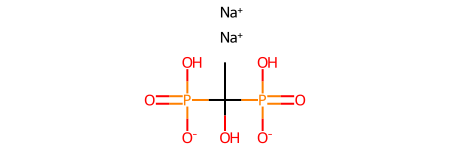

In [36]:
mol

In [26]:
import networkx as nx

In [ ]:
mol

In [44]:
x_map = {
    "atomic_num": list(range(0, 119)),
    "chirality": [
        "CHI_UNSPECIFIED",
        "CHI_TETRAHEDRAL_CW",
        "CHI_TETRAHEDRAL_CCW",
        "CHI_OTHER",
    ],
    "degree": list(range(0, 11)),
    "formal_charge": list(range(-5, 7)),
    "num_hs": list(range(0, 9)),
    "num_radical_electrons": list(range(0, 5)),
    "hybridization": [
        "UNSPECIFIED",
        "S",
        "SP",
        "SP2",
        "SP3",
        "SP3D",
        "SP3D2",
        "OTHER",
    ],
    "is_aromatic": [False, True],
    "is_in_ring": [False, True],
}

e_map = {
    "bond_type": [
        "misc",
        "SINGLE",
        "DOUBLE",
        "TRIPLE",
        "AROMATIC",
    ],
    "stereo": [
        "STEREONONE",
        "STEREOZ",
        "STEREOE",
        "STEREOCIS",
        "STEREOTRANS",
        "STEREOANY",
    ],
    "is_conjugated": [False, True],
}

def from_smiles(smiles: str, with_hydrogen: bool = False, kekulize: bool = False):
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.
    Args:
        smiles (string, optional): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """

    RDLogger.DisableLog("rdApp.*")

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles("")
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        mol = Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map["atomic_num"].index(atom.GetAtomicNum()))
        x.append(x_map["chirality"].index(str(atom.GetChiralTag())))
        x.append(x_map["degree"].index(atom.GetTotalDegree()))
        x.append(x_map["formal_charge"].index(atom.GetFormalCharge()))
        x.append(x_map["num_hs"].index(atom.GetTotalNumHs()))
        x.append(x_map["num_radical_electrons"].index(atom.GetNumRadicalElectrons()))
        x.append(x_map["hybridization"].index(str(atom.GetHybridization())))
        x.append(x_map["is_aromatic"].index(atom.GetIsAromatic()))
        x.append(x_map["is_in_ring"].index(atom.IsInRing()))
        xs.append(x)
        
        #xs.append(atom.GetSymbol())

    x = torch.tensor(xs, dtype=torch.long).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map["bond_type"].index(str(bond.GetBondType())))
        e.append(e_map["stereo"].index(str(bond.GetStereo())))
        e.append(e_map["is_conjugated"].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return xs, edge_index, edge_attr, smiles

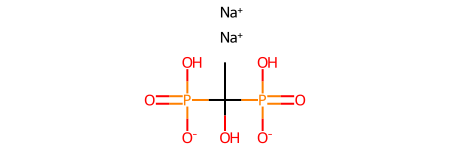

In [45]:
mol

In [46]:
x,e,ef,s = from_smiles("CC(O)(P(=O)([O-])O)P(=O)([O-])O.[Na+].[Na+]")

In [47]:
e

tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])

In [52]:
edge_to_i = e[1] == 0

In [51]:
edge_from_j = e[0] == 1

In [54]:
torch.where(edge_to_i & edge_from_j)

(tensor([1]),)

In [55]:
def get_reverse_edge_indices(edge_index):
    revedge_index = torch.zeros(edge_index.shape[1]).long()
    for k, (i, j) in enumerate(zip(*edge_index)):
        edge_to_i = edge_index[1] == i
        edge_from_j = edge_index[0] == j
        revedge_index[k] = torch.where(edge_to_i & edge_from_j)[0]
    return revedge_index

In [56]:
get_reverse_edge_indices(e)

tensor([ 1,  0,  5,  6, 13,  2,  3, 10, 11, 12,  7,  8,  9,  4, 17, 18, 19, 14,
        15, 16])

In [39]:
dir(list(mol.GetAtoms())[0])

['ClearProp',
 'DescribeQuery',
 'GetAtomMapNum',
 'GetAtomicNum',
 'GetBonds',
 'GetBoolProp',
 'GetChiralTag',
 'GetDegree',
 'GetDoubleProp',
 'GetExplicitBitVectProp',
 'GetExplicitValence',
 'GetFormalCharge',
 'GetHybridization',
 'GetIdx',
 'GetImplicitValence',
 'GetIntProp',
 'GetIsAromatic',
 'GetIsotope',
 'GetMass',
 'GetMonomerInfo',
 'GetNeighbors',
 'GetNoImplicit',
 'GetNumExplicitHs',
 'GetNumImplicitHs',
 'GetNumRadicalElectrons',
 'GetOwningMol',
 'GetPDBResidueInfo',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetQueryType',
 'GetSmarts',
 'GetSymbol',
 'GetTotalDegree',
 'GetTotalNumHs',
 'GetTotalValence',
 'GetUnsignedProp',
 'HasOwningMol',
 'HasProp',
 'HasQuery',
 'InvertChirality',
 'IsInRing',
 'IsInRingSize',
 'Match',
 'NeedsUpdatePropertyCache',
 'SetAtomMapNum',
 'SetAtomicNum',
 'SetBoolProp',
 'SetChiralTag',
 'SetDoubleProp',
 'SetExplicitBitVectProp',
 'SetFormalCharge',
 'SetHybridization',
 'SetIntProp',
 'SetIsAromatic',
 'SetIsotope',
 'Set

# EColi

In [1]:
import json 
from cobra.io import load_matlab_model
from collections import Counter

In [103]:
import rdkit
from rdkit import Chem

In [2]:
json_model = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/datasets/iML1515_dataset.json", "r"))
matlab_model = load_matlab_model("/Mounts/rbg-storage1/datasets/Metabo/BiGG/iML1515.mat")


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [6]:
rxnlens = [ len(r.metabolites) for r in matlab_model.reactions ]

In [11]:
rxnlens[0]

5

In [9]:
Counter(rxnlens)

[(4, 742),
 (5, 612),
 (2, 482),
 (1, 337),
 (6, 182),
 (7, 177),
 (3, 141),
 (8, 23),
 (9, 9),
 (12, 2),
 (10, 1),
 (11, 1),
 (13, 1),
 (70, 1),
 (99, 1)]

In [14]:
long_rxns = [ r for r in matlab_model.reactions if len(r.metabolites) > 9]

In [15]:
long_rxns

[<Reaction S2FE2SR at 0x7fc5e9e3c8b0>,
 <Reaction S2FE2SS at 0x7fc5e9e5d370>,
 <Reaction S2FE2SS2 at 0x7fc5e9e0dc70>,
 <Reaction LIPOS at 0x7fc5e9e0dd00>,
 <Reaction THZPSN3 at 0x7fc5e9d8d970>,
 <Reaction BIOMASS_Ec_iML1515_core_75p37M at 0x7fc5e9d26b20>,
 <Reaction BIOMASS_Ec_iML1515_WT_75p37M at 0x7fc5e9d26eb0>]

In [30]:
len(long_rxns[].metabolites)

99

In [29]:
long_rxns[6]

Reaction identifier,BIOMASS_Ec_iML1515_WT_75p37M
Name,E. coli biomass objective function (iML1515) - WT - with 75.37 GAM estimate
Memory address,0x7fc5e9d26eb0
Stoichiometry,0.000223 10fthf_c + 0.000223 2dmmql8_c + 2.5e-05 2fe2s_c + 0.000248 4fe4s_c + 0.000223 5mthf_c + 0.000279 accoa_c + 0.000223 adocbl_c + 0.499149 ala__L_c + 0.000223 amet_c + 0.28742 arg__L_c +... 0.000223 10-Formyltetrahydrofolate + 0.000223 2-Demethylmenaquinol 8 + 2.5e-05 [2Fe-2S] iron-sulfur cluster + 0.000248 [4Fe-4S] iron-sulfur cluster + 0.000223 5-Methyltetrahydrofolate + 0.000279...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [42]:
long_rxns[6].id, long_rxns[5].id

('BIOMASS_Ec_iML1515_WT_75p37M', 'BIOMASS_Ec_iML1515_core_75p37M')

In [31]:
matlab_model

Name,iML1515
Memory address,0x07fc495480700
Number of metabolites,1877
Number of reactions,2712
Number of groups,40
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"c, e, p"


In [43]:
rxns = [ r for r in matlab_model.reactions if "BIOMASS" not in r.id]

In [47]:
json_model = [r for r in json_model if "BIOMASS" not in r["rxn_id"]]

In [48]:
len(json_model)

2710

In [101]:
reaction_str = []
reaction_id = []
unknown_mets = []
for rxn_dict in json_model:
    if rxn_dict.get("reactants", False) and rxn_dict.get("products", False):
        reaction_str.append( "{}>>{}".format(    
        ".".join([r['smiles'] for r in rxn_dict["reactants"] if r['smiles'] is not None]),
        ".".join([ r['smiles'] for r in rxn_dict["products"] if r['smiles'] is not None ])
        )
    )
        reaction_id.append(rxn_dict["rxn_id"])
    
    if rxn_dict.get("reactants", False):
        unk = [r['metabolite_id'] for r in rxn_dict["reactants"] if r['smiles'] is None]
        unknown_mets.extend(unk)
    if rxn_dict.get("products", False):
        unk = [r['metabolite_id'] for r in rxn_dict["products"] if r['smiles'] is None]
        unknown_mets.extend(unk)

In [58]:
len(reaction_str)

2373

In [64]:
rxnlens = [(len(s), i) for s, i in zip(reaction_str,reaction_id) ]

In [72]:
rxnlens = sorted(rxnlens, key = lambda x: x[0], reverse = True)

In [ ]:
(3499, 'O16A4COLIPAabctex'),
(2482, 'O16A4Lpp'),
(1888, 'ECA4OALpp'),
(1725, 'ACOLIPAabctex'),
(1667, 'ECA4COLIPAabctex'),
(1667, 'COLIPAPabctex'),
(1457, 'LA4NTpp'),
(1454, 'LIPAHT2ex'),
(1434, 'COLIPAKpp'),
(1281, 'COLIPAabcpp'),
(1281, 'COLIPAabctex'),
(1220, 'ECAP3pp'),
(1211, 'HEPK2'),
(1072, 'HEPT3'),
(1046, 'ECAP2pp'),
(1041, 'MPTG2'),

In [87]:
[r for r in matlab_model.reactions if r.id == "MPTG2"][0]

Reaction identifier,MPTG2
Name,Murein polymerizing transglycosylase 2 (three linked units)
Memory address,0x7fc5e9f9b6d0
Stoichiometry,"murein5p5p_p + uaagmda_c --> h_c + murein5p5p5p_p + udcpdp_c Two linked disacharide pentapeptide murein units (uncrosslinked, middle of chain) + Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L-ala-D-glu-meso-2,6-diaminopimeloyl-D-ala-D-ala..."
GPR,(b0149 and b1069 and b0089) or (b1069 and b0089 and b3208) or (b3396 and b1069 and b0089) or...
Lower bound,0.0
Upper bound,1000.0


In [91]:
set(unknown_mets)

{'14glucan_c',
 '14glucan_e',
 '14glucan_p',
 'alpp_p',
 'anhgm4p_c',
 'anhgm4p_p',
 'clpn161_p',
 'clpn181_p',
 'fe3hox_c',
 'fe3hox_e',
 'fe3hox_p',
 'flxr_c',
 'flxso_c',
 'grxox_c',
 'grxrd_c',
 'iscssh_c',
 'iscu_2fe2s2_c',
 'iscu_2fe2s_c',
 'iscu_4fe4s_c',
 'iscu_c',
 'moadamp_c',
 'moadcoo_c',
 'moadcosh_c',
 'ocdceap_c',
 'ogmeACP_c',
 'opmeACP_c',
 'puacgam_c',
 'puacgam_p',
 'sufbcd_2fe2s2_c',
 'sufbcd_2fe2s_c',
 'sufbcd_4fe4s_c',
 'sufbcd_c',
 'sufse_c',
 'sufsesh_c',
 'xylu__D_c'}

In [98]:
metmeta = {}
for rxn_dict in json_model:
    for r in rxn_dict.get("reactants", []) :
        metmeta[r["metabolite_id"]] = r
    for r in rxn_dict.get("products", []) :
        metmeta[r["metabolite_id"]] = r
    
    

In [324]:
unknown_mets_mat = [j for j in matlab_model.metabolites if j.id in set(unknown_mets) ]

In [325]:
len(unknown_mets_mat)

35

In [102]:
[ metmeta[k] for k in set(unknown_mets)]

[{'metabolite_id': 'clpn161_p',
  'coefficient': 1.0,
  'biocyc_id': 'META:CPD-19674',
  'biocyc_inchi': 'InChI=1S/C73H134O17P2/c1-5-9-13-17-21-25-29-33-37-41-45-49-53-57-70(75)83-63-68(89-72(77)59-55-51-47-43-39-35-31-27-23-19-15-11-7-3)65-87-91(79,80)85-61-67(74)62-86-92(81,82)88-66-69(90-73(78)60-56-52-48-44-40-36-32-28-24-20-16-12-8-4)64-84-71(76)58-54-50-46-42-38-34-30-26-22-18-14-10-6-2/h25-32,67-69,74H,5-24,33-66H2,1-4H3,(H,79,80)(H,81,82)/p-2/b29-25+,30-26+,31-27+,32-28+/t68-,69-/m1/s1',
  'biocyc_inchikey': 'InChIKey=UYSHBKYVDAZLKJ-FADMWBLTSA-L',
  'biocyc_smiles': 'C(OP([O-])(OC[C@H](OC(=O)[R4])COC(=O)[R3])=O)[C@H](O)COP([O-])(OC[C@H](OC(=O)[R2])COC(=O)[R1])=O',
  'searched': False,
  'errors': None,
  'smiles': None},
 {'metabolite_id': 'iscssh_c',
  'coefficient': -1.0,
  'searched': True,
  'errors': None,
  'smiles': None},
 {'metabolite_id': 'iscu_c',
  'coefficient': -1.0,
  'searched': True,
  'errors': None,
  'smiles': None},
 {'metabolite_id': 'grxox_c',
  'coeffici

In [143]:
import sys
sys.path.append("/Mounts/rbg-storage1/users/pgmikhael/nox/scripts/data")
from bigg_scraper import *

In [145]:
from bigg_scraper import *

In [128]:
def xml2dict(t):
    """Transform XML into dictionary

    Args:
        t (ET.XML): xml object

    Returns:
        dict: dictionary version of xml object
    """
    d = {}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(xml2dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v for k, v in dd.items()}}

    if t.text:
        text = t.text.strip()
        if not text == "":
            d[t.tag] = text
    return d

In [117]:
BIGG_METABOLITES = pd.read_csv(
    "/Mounts/rbg-storage1/datasets/Metabo/BiGG/bigg_models_metabolites.txt", sep="\t"
)
BIGG_METABOLITES.fillna("", inplace=True)

METANETX_METABOLITES = pd.read_csv(
    "/Mounts/rbg-storage1/datasets/Metabo/MetaNetX/chem_prop.tsv",
    sep="\t",
    skiprows=351,
)
METANETX_METABOLITES.fillna("", inplace=True)
HMDB_METABOLITES = json.load(
    open("/Mounts/rbg-storage1/datasets/Metabo/HMDB/metabolites.json", "r")
)

CHEBI_DB = json.load(open("/Mounts/rbg-storage1/datasets/Metabo/chebi_db.json", "r"))

In [387]:
# functions from torch_geometric.utils not yet importable
from rdkit import Chem, RDLogger
from typing import List
import torch
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.utils import degree


x_map = {
    "atomic_num": list(range(0, 119)),
    "chirality": [
        "CHI_UNSPECIFIED",
        "CHI_TETRAHEDRAL_CW",
        "CHI_TETRAHEDRAL_CCW",
        "CHI_OTHER",
    ],
    "degree": list(range(0, 11)),
    "formal_charge": list(range(-5, 7)),
    "num_hs": list(range(0, 9)),
    "num_radical_electrons": list(range(0, 5)),
    "hybridization": [
        "UNSPECIFIED",
        "S",
        "SP",
        "SP2",
        "SP3",
        "SP3D",
        "SP3D2",
        "OTHER",
    ],
    "is_aromatic": [False, True],
    "is_in_ring": [False, True],
}

e_map = {
    "bond_type": [
        "misc",
        "SINGLE",
        "DOUBLE",
        "TRIPLE",
        "AROMATIC",
    ],
    "stereo": [
        "STEREONONE",
        "STEREOZ",
        "STEREOE",
        "STEREOCIS",
        "STEREOTRANS",
        "STEREOANY",
    ],
    "is_conjugated": [False, True],
}


def unbatch(src: Tensor, batch: Tensor, dim: int = 0) -> List[Tensor]:
    r"""Splits :obj:`src` according to a :obj:`batch` vector along dimension
    :obj:`dim`.

    Args:
        src (Tensor): The source tensor.
        batch (LongTensor): The batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns each
            entry in :obj:`src` to a specific example. Must be ordered.
        dim (int, optional): The dimension along which to split the :obj:`src`
            tensor. (default: :obj:`0`)

    :rtype: :class:`List[Tensor]`
    """
    sizes = degree(batch, dtype=torch.long).tolist()
    return src.split(sizes, dim)


def from_smiles(mol, with_hydrogen: bool = False, kekulize: bool = False):
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.
    Args:
        smiles (string, optional): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """

    RDLogger.DisableLog("rdApp.*")

    if mol is None:
        mol = Chem.MolFromSmiles("")
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        mol = Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map["atomic_num"].index(atom.GetAtomicNum()))
        x.append(x_map["chirality"].index(str(atom.GetChiralTag())))
        # x.append(x_map["degree"].index(atom.GetTotalDegree()))  # SMARTS
        x.append(x_map["formal_charge"].index(atom.GetFormalCharge()))
        # x.append(x_map["num_hs"].index(atom.GetTotalNumHs()))  # SMARTS
        x.append(x_map["num_radical_electrons"].index(atom.GetNumRadicalElectrons()))
        x.append(x_map["hybridization"].index(str(atom.GetHybridization())))
        x.append(x_map["is_aromatic"].index(atom.GetIsAromatic()))
        x.append(x_map["is_in_ring"].index(atom.IsInRing()))
        xs.append(x)

    x = torch.tensor(xs, dtype=torch.long).view(-1, 6)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map["bond_type"].index(str(bond.GetBondType())))
        e.append(e_map["stereo"].index(str(bond.GetStereo())))
        e.append(e_map["is_conjugated"].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [388]:
smarts_mol = Chem.MolFromSmarts("OC[C@@]1(O)OC[C@@H](O)[C@@H]1O")

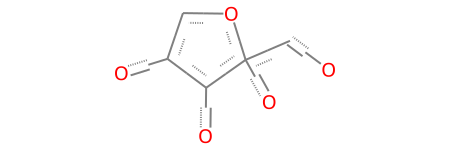

In [389]:
smarts_mol

In [395]:
for atom in smarts_mol.GetAtoms(): 
    print(str(atom.GetHybridization()))

UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED
UNSPECIFIED


In [390]:
smiles_mol = Chem.MolFromSmiles("OC[C@@]1(O)OC[C@@H](O)[C@@H]1O")

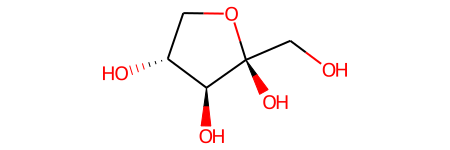

In [391]:
smiles_mol

In [392]:
smarts_d = from_smiles(smarts_mol)
smiles_d = from_smiles(smiles_mol)

In [393]:
smarts_d

Data(x=[10, 6], edge_index=[2, 20], edge_attr=[20, 3])

In [380]:
smarts_d.x, smiles_d.x

(tensor([[8, 0, 5, 0, 0, 0, 0],
         [6, 0, 5, 0, 0, 0, 0],
         [6, 1, 5, 0, 0, 0, 1],
         [8, 0, 5, 0, 0, 0, 0],
         [8, 0, 5, 0, 0, 0, 1],
         [6, 0, 5, 0, 0, 0, 1],
         [6, 1, 5, 0, 0, 0, 1],
         [8, 0, 5, 0, 0, 0, 0],
         [6, 2, 5, 0, 0, 0, 1],
         [8, 0, 5, 0, 0, 0, 0]]),
 tensor([[8, 0, 5, 0, 4, 0, 0],
         [6, 0, 5, 0, 4, 0, 0],
         [6, 1, 5, 0, 4, 0, 1],
         [8, 0, 5, 0, 4, 0, 0],
         [8, 0, 5, 0, 4, 0, 1],
         [6, 0, 5, 0, 4, 0, 1],
         [6, 1, 5, 0, 4, 0, 1],
         [8, 0, 5, 0, 4, 0, 0],
         [6, 2, 5, 0, 4, 0, 1],
         [8, 0, 5, 0, 4, 0, 0]]))

In [394]:
torch.equal(smarts_d.x, smiles_d.x)

True

In [383]:
torch.equal(smarts_d.edge_index, smiles_d.edge_index)

True

In [385]:
torch.equal(smarts_d.edge_attr, smiles_d.edge_attr)

True

In [396]:
from rdkit.Chem import AllChem

In [397]:
smiles_fp = AllChem.GetMorganFingerprintAsBitVect(smiles_mol, radius=2, nBits=2048)

In [398]:
smarts_fp = AllChem.GetMorganFingerprintAsBitVect(smarts_mol, radius=2, nBits=2048)

array([0, 0, 0, ..., 0, 0, 0])

In [409]:
np.where(np.array(smarts_fp) != np.array(smiles_fp))

(array([  80,  171,  175,  214,  222,  412,  576,  621,  650,  674,  755,
         807,  849,  891,  926, 1017, 1073, 1077, 1087, 1154, 1257, 1380,
        1413, 1468, 1503, 1504, 1664, 1717, 1721, 1762, 1772, 1923, 1960,
        1979, 1990, 1998]),)

In [412]:
np.where(np.array(smarts_fp) ==1)

(array([ 214,  412,  576,  621,  650,  656,  674, 1019, 1060, 1077, 1087,
        1468, 1503, 1504, 1721, 1762, 1772, 1960, 1979, 1990, 1998]),)

In [413]:
np.where(np.array(smiles_fp) ==1)

(array([  80,  171,  175,  222,  656,  755,  807,  849,  891,  926, 1017,
        1019, 1060, 1073, 1154, 1257, 1380, 1413, 1664, 1717, 1923]),)

In [321]:
rid = "sufse_c" 
db_meta = BIGG_METABOLITES[BIGG_METABOLITES["bigg_id"] == rid]["database_links"]

In [322]:
db_meta.iloc[0]

'MetaNetX (MNX) Chemical: http://identifiers.org/metanetx.chemical/MNXM147309'

In [316]:
METANETX_METABOLITES[METANETX_METABOLITES["#ID"] == "MNXM729075"]

,#ID,name,reference,formula,charge,mass,InChI,InChIKey,SMILES
1010748,MNXM729075,Glutaredoxin (oxidized),biggM:grxox,C6H7NO2S2*,,,,,[*]C(=O)C1CSSCC([*])C(=O)N1


In [281]:
METANETX_METABOLITES[METANETX_METABOLITES["#ID"] == "MNXM729075"]

,#ID,name,reference,formula,charge,mass,InChI,InChIKey,SMILES
1010748,MNXM729075,Glutaredoxin (oxidized),biggM:grxox,C6H7NO2S2*,,,,,[*]C(=O)C1CSSCC([*])C(=O)N1


In [275]:
[f for f in db_meta.values[0].split(";") if "hmdb" in f]

[]

In [264]:
HMDB_METABOLITES['HMDB0001644']

{'version': '5.0',
 'creation_date': '2005-11-20 22:13:13 UTC',
 'update_date': '2021-09-14 15:44:47 UTC',
 'accession': 'HMDB0001644',
 'status': 'quantified',
 'secondary_accessions': {'accession': ['HMDB0000654',
   'HMDB00654',
   'HMDB01644']},
 'name': 'D-Xylulose',
 'synonyms': {'synonym': ['b-D-Xylulofuranose',
   'Β-D-xylulofuranose',
   'D-Lyxulose',
   'D-Threo-2-pentulose',
   'D-Threo-pentulose',
   'Xylulose',
   'beta-D-Threo-2-pentulofuranose',
   'beta-D-Threo-pentulofuranose',
   'Β-D-threo-2-pentulofuranose',
   'Β-D-threo-pentulofuranose',
   'D-Xylulose']},
 'chemical_formula': 'C5H10O5',
 'average_molecular_weight': '150.1299',
 'monisotopic_molecular_weight': '150.05282343',
 'iupac_name': '(2R,3S,4R)-2-(hydroxymethyl)oxolane-2,3,4-triol',
 'traditional_iupac': '(2R,3S,4R)-2-(hydroxymethyl)oxolane-2,3,4-triol',
 'cas_registry_number': '20750-28-1',
 'smiles': 'OC[C@@]1(O)OC[C@@H](O)[C@@H]1O',
 'inchi': 'InChI=1S/C5H10O5/c6-2-5(9)4(8)3(7)1-10-5/h3-4,6-9H,1-2H2/t3-

In [231]:
[0]*(11 - len('HMDB01644'))

[0, 0]

In [262]:
def met():
    for i in range(10):
        #print(i, (i+1) % 2 == 0)
        if (i+1) % 2 == 0:
            return i
    return 'nope'

In [263]:
met()

1

In [ ]:
mol = Chem.MolFromSmarts("*C(=O)C(N)CS*")

In [272]:
Chem.MolFromSmiles("C[C@H](NC([C@H](O[C@@H]2([C@@H](NC(=O)C)C3(OCC([C@@H](O[C@@H]1(O[C@H](CO)[C@@H](O)[C@H](O)[C@@H](NC(=O)C)1))2)O3)))C)=O)C(N[C@H](CCC(=O)N[C@@H](CCCC([R])[NH3+])C(N[C@H](C)C(=O)[O-])=O)C(=O)[O-])=O")

In [349]:
from matplotlib import pyplot as plt

In [356]:
import numpy as np

In [344]:
soln =matlab_model.optimize()

In [348]:
soln.fluxes

-47.16236480869448

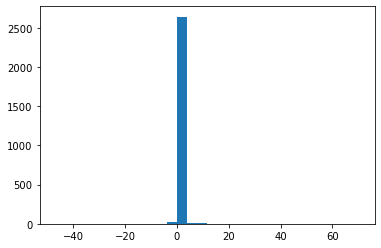

In [352]:
plt.hist(list(soln.fluxes), bins = 30)
plt.show()

In [359]:
np.linalg.norm(np.array(soln.fluxes), 2)

144.6244833191663

In [431]:
rxns_affectede = list(set([r.id for u in unknown_mets_mat for r in u.reactions]))

In [427]:
len(set(rxns_affectede))

70

In [457]:
matlab_model = load_matlab_model("/Mounts/rbg-storage1/datasets/Metabo/BiGG/iML1515.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [458]:
soln = matlab_model.optimize()

In [459]:
soln.objective_value

0.876997214426967

In [ ]:
matlab_model = load_matlab_model("/Mounts/rbg-storage1/datasets/Metabo/BiGG/iML1515.mat")

In [442]:
matlab_model.remove_reactions(rxns_affectede)

In [443]:
soln = matlab_model.optimize()

In [444]:
soln.objective_value

0.876997214426967

In [467]:
matlab_model = load_matlab_model("/Mounts/rbg-storage1/datasets/Metabo/BiGG/iML1515.mat")

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [454]:
unknown_mets_mat 

[<Metabolite 14glucan_p at 0x7fc5fc7e38b0>,
 <Metabolite iscu_2fe2s_c at 0x7fc5fc7e3d00>,
 <Metabolite flxr_c at 0x7fc5fc7e3e50>,
 <Metabolite clpn161_p at 0x7fc5fc7e3fd0>,
 <Metabolite iscssh_c at 0x7fc5fc7de130>,
 <Metabolite sufbcd_2fe2s_c at 0x7fc5fc769370>,
 <Metabolite alpp_p at 0x7fc5fc775700>,
 <Metabolite moadamp_c at 0x7fc5fc7759d0>,
 <Metabolite puacgam_p at 0x7fc5fc78b280>,
 <Metabolite sufsesh_c at 0x7fc5fc797640>,
 <Metabolite xylu__D_c at 0x7fc5fc797940>,
 <Metabolite ogmeACP_c at 0x7fc5fc7a21c0>,
 <Metabolite sufse_c at 0x7fc5fc7a22b0>,
 <Metabolite iscu_2fe2s2_c at 0x7fc5fc72e5e0>,
 <Metabolite clpn181_p at 0x7fc5fc72ebb0>,
 <Metabolite anhgm4p_c at 0x7fc5fc72ed60>,
 <Metabolite grxrd_c at 0x7fc5fc72eeb0>,
 <Metabolite puacgam_c at 0x7fc5fc744a60>,
 <Metabolite anhgm4p_p at 0x7fc5fc75b4c0>,
 <Metabolite 14glucan_c at 0x7fc5fc6e6610>,
 <Metabolite moadcoo_c at 0x7fc5fc6e68e0>,
 <Metabolite flxso_c at 0x7fc5fc6f25e0>,
 <Metabolite sufbcd_c at 0x7fc5fc6fdeb0>,
 <Metabolit

In [465]:
unknown_mets_mat[1]._model

In [466]:
len(matlab_model.metabolites)

1877

In [464]:
matlab_model.remove_metabolites([unknown_mets_mat[1]], destructive = False)

ValueError: Another object with the identical id (iscu_2fe2s_c) found

In [ ]:
soln = matlab_model.optimize()

In [ ]:
soln.objective_value

In [468]:
unknown_mets = []
for rxn_dict in json_model:

    if rxn_dict.get("reactants", False):
        unk = [r['metabolite_id'] for r in rxn_dict["reactants"] if r['smiles'] is None]
        unknown_mets.extend(unk)
    
    if rxn_dict.get("products", False):
        unk = [r['metabolite_id'] for r in rxn_dict["products"] if r['smiles'] is None]
        unknown_mets.extend(unk)

unknown_mets_mat = list(set([j for j in matlab_model.metabolites if j.id in set(unknown_mets) ]))
matlab_model.remove_metabolites(unknown_mets_mat, destructive = False)

In [469]:
soln = matlab_model.optimize()

In [470]:
soln.objective_value

41.50397032165155

In [474]:
matlab_model

'max'